#### I'm using this notebook to figure out what the missing parameters in the FakeAlmaden hamiltonian are. So far, I know that omegad0 is 0.1675, omegad1 is 0.176, jq0q1 is 0.0135.
----

Setting up pulse simulator:

1) switch to openpulse-sim branch of qiskit-aer, also include this pull request https://github.com/Qiskit/qiskit-aer/pull/451 and increase `nsteps` in qiskit-aer/qiskit/providers/aer/openpulse/solver/options.py (I upped 100x to 50000)

2) run `python setup.py build_ext --inplace`

3) `python ./setup.py bdist_wheel`

4) `cd dist` and `pip install` the wheel

5) `rm -rf /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (replace with your username / site-packages location)

6) `ln -s /Users/pranavgokhale/Developer/qiskit/qiskit-aer/qiskit/ /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (tailor paths to your setup)

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Import Qiskit classes classes
import qiskit
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
import random
from qiskit.test.mock import FakeAlmaden

In [2]:
#Get a pulse configuration from the fake backend
backend_real = FakeAlmaden()
back_config = backend_real.configuration().to_dict()
system = pulse.PulseChannelSpec.from_backend(backend_real)

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [3]:
#Get pulse simulator backend
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

In [4]:
cmd_def = qiskit.pulse.CmdDef.from_defaults(backend_real.defaults().cmd_def, backend_real.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend_real.configuration().meas_map[0])

In [5]:
schedule = cmd_def.get('x', qubits=[0])
schedule |= measure << schedule.duration
schedules = [schedule]

### Design the Hamiltonian

Let's build a transmon Hamiltonian with anharmonicity to test the Rabi oscillation and CR

In [6]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 0.176,
                       'jq0q1': 0.0135}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0

In [7]:
back_config['ode_options'] = {}

In [8]:
back_config['qubit_list'] = [0,1]
#back_config['qubit_list'] = list(range(20))
#back_config['qubit_list'] = None

In [12]:
shots = 10000
rabi_qobj = assemble(schedules, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2,
                     shots=shots, sim_config = back_config)

In [13]:
evals, estates = backend_sim.get_dressed_energies(rabi_qobj)

In [14]:
evals/2/np.pi

array([0.        , 4.85717964, 4.97175886, 9.82893851])

In [15]:
rabi_qobj = assemble(schedules, backend_real, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)

### omegad0

In [67]:
sim_result = backend_sim.run(rabi_qobj).result()

In [85]:
counts = []
omegad0s = np.linspace(0.166, 0.169, 10)
for omegad0 in omegad0s:
    back_config['hamiltonian']['vars']['omegad0'] = omegad0
    rabi_qobj = assemble(schedules, backend_real, 
                         qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                         shots=20000, sim_config = back_config)
    sim_result = backend_sim.run(rabi_qobj).result()
    counts.append(sim_result.get_counts().get('00000000000000000001', 0))

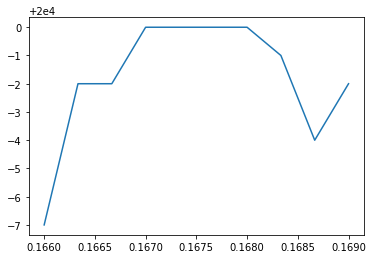

In [86]:
plt.plot(omegad0s, counts)

In [87]:
back_config['hamiltonian']['vars']['omegad0'] = 0.1675

-----
## omegad1

In [88]:
schedule = cmd_def.get('x', qubits=[1])
schedule |= measure << schedule.duration
schedules = [schedule]

In [95]:
counts = []
omegad1s = np.linspace(0.175, 0.179, 10)
for omegad1 in omegad1s:
    back_config['hamiltonian']['vars']['omegad1'] = omegad1
    rabi_qobj = assemble(schedules, backend_real, 
                         qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                         shots=10000, sim_config = back_config)
    sim_result = backend_sim.run(rabi_qobj).result()
    counts.append(sim_result.get_counts().get('00000000000000000010', 0))

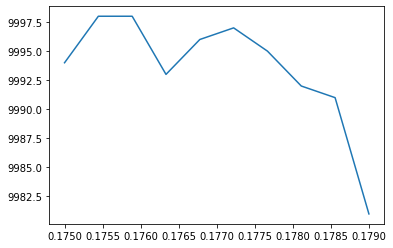

In [96]:
plt.plot(omegad1s, counts)

In [97]:
back_config['hamiltonian']['vars']['omegad1'] = 0.176

----
## jq0q1

In [19]:
import pulse_compiler_helper_fns

In [30]:
schedule = pulse_compiler_helper_fns.get_cr_schedule(np.pi/2, 0, 1, cmd_def, system)
schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
schedule |= measure << schedule.duration
qobj = assemble(schedule, backend_real, 
                qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                shots=10000, sim_config = back_config)

In [35]:
counts = []
jq0q1s = np.linspace(0.012, 0.015, 6)
for jq0q1 in jq0q1s:
    back_config['hamiltonian']['vars']['jq0q1'] = jq0q1
    rabi_qobj = assemble(schedule, backend_real, 
                         qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                         shots=10000, sim_config = back_config)
    sim_result = backend_sim.run(rabi_qobj).result()
    counts.append(sim_result.get_counts().get('00000000000000000011', 0))

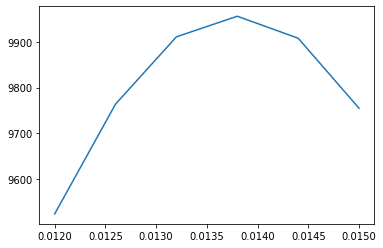

In [36]:
plt.plot(jq0q1s, counts)

In [29]:
back_config['hamiltonian']['vars']['jq0q1'] = 0.0135